# HW2-1: Convolutional neural networks (numpy)
In this exercise, we will implement several layer types that are used in convolutional networks.
You will be asked to complete several functions/classes used below in `HW_YourAnswer.py`.
- Convolution forward / backward
- (Max / Average) Pooling forward / backward
- Batch normalization (for CNN) forward / backward

You will then use these layers to train a three-layer convolutional network on the CIFAR-10 dataset  in `HW_YourAnswer_cnn.py`.

In [ ]:
#Colab setting cell
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/your_directory')

import os
os.chdir('/content/drive/My Drive/your_directory')

In [1]:
%load_ext autoreload
%autoreload 2

# Setup cell.
import numpy as np
import matplotlib.pyplot as plt
from IPython import display


from utils import *
from HW_YourAnswer import *
from HW_YourAnswer_cnn import *

%matplotlib inline


# Exercise 1: Convolution layer

## Exercise 1.1: forward pass of convolution layer

We will implement forward pass of convolution layer:
 1. consider input data of shape (N, H, W, C) and filter of shape (F, FH, FW, C)

    N: the number of input, H: height of input, W: width of input, C: channel
    
    F: the number of filter, FH: height of filter, FW: width of filter, C: filter channel

    
 2. consider zero-padding, stride, and bias.



<img src="https://github.com/csaybar/DLcoursera/blob/master/Convolutional%20Neural%20Networks/week01/images/Convolution_schematic.gif?raw=1" style="width:500px;height:300px;">

**Simple example of convolution operation**<br> with a filter of 3x3 (no bias term), no zero-padding, and a stride of 1  


#### For this, we will learn and implement **helpful functions** first.



### 1) Zero-Padding

Before implementing it, let's learn about numpy.pad function.

Zero-padding adds zeros around the border of an image ( Image (3 channels, RGB) with a pad=2 case):

 <img src="https://github.com/csaybar/DLcoursera/blob/master/Convolutional%20Neural%20Networks/week01/images/PAD.png?raw=1" style="width:600px;height:400px;">



We will use 'pad' function in numpy library (https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html).

if you want to pad the array with a different padding size for each dimension, for example padding size 1 for 2nd dimension, 3 for 4th dimension, and no padding for the rest, use following commands:
```python
arr = np.pad(arr, ((0,0), (1,1), (0,0), (3,3), (0,0)), 'constant', constant_values = (..,..))
```
Note that default padding value is 0 if mode is ‘constant’ and we use default constant_values.

For further description, please read : https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html

Let's check with simple example.

- x: input data of shape (N, H, W, C)
- pad: the number of pixels for padding.



In [2]:

# 1 x 4 x 4 x 1 example, pad=1
pad=1
original_matrix= np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
original_matrix=np.expand_dims(original_matrix,axis=(0,-1))

# Shape of original matrix:  (1, 4, 4, 1)
print("arr shape: ", original_matrix.shape)

padded_matrix =np.pad(original_matrix, ((0, 0),  (pad, pad), (pad, pad), (0, 0)), mode='constant')
print("original matrix:\n",original_matrix[0,:,:,0])
print("padded matrix:\n", padded_matrix[0,:,:,0])

arr shape:  (1, 4, 4, 1)
original matrix:
 [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
padded matrix:
 [[ 0  0  0  0  0  0]
 [ 0  1  2  3  4  0]
 [ 0  5  6  7  8  0]
 [ 0  9 10 11 12  0]
 [ 0 13 14 15 16  0]
 [ 0  0  0  0  0  0]]


### 2) Find the receptive field

Here, we implement extracting the receptive field or region of interest (ROI) from the **single** input tensor `x` for a given position (i, j) in the output feature map `O`.

This ROI is the area that the filter w will overlap during the convolution process.

Given a specific position (i, j) in the output feature map, the function determines and extracts this region from the input tensor.

Below image will help understanding.




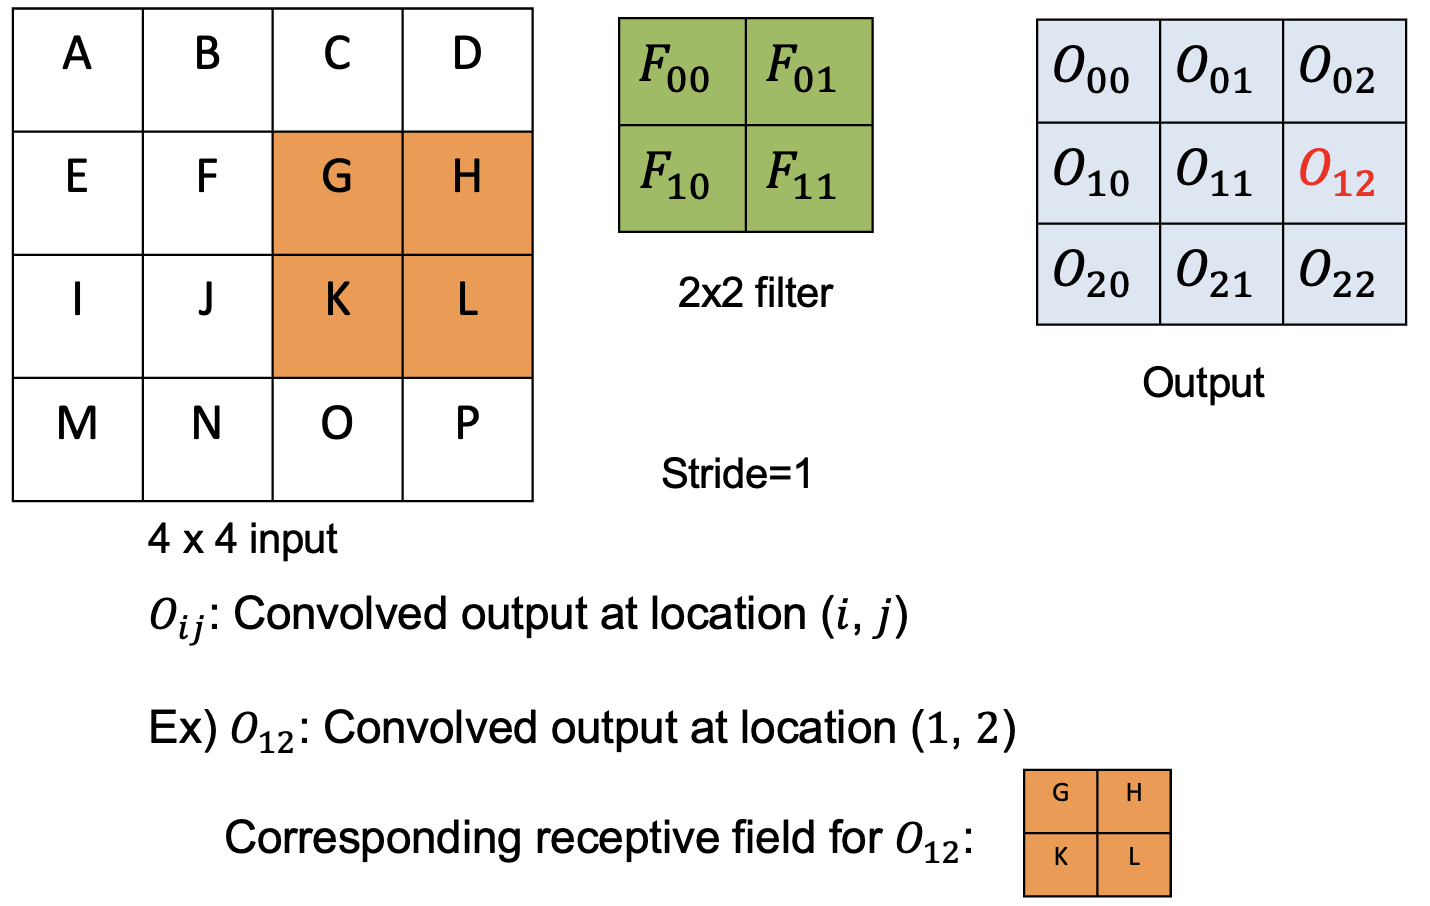

In [3]:
display.Image("figures/roi.png",width=500,height=300)



Input: x,i,j,FH,FW,stride
  - x (numpy.ndarray): **Single** input tensor with shape (H, W, C), where:
      * H is the height of the input.
      * W is the width of the input.
      * C is the number of channels.
  - i (int): Vertical index representing the number of strides taken along the height of the input.
  - j (int): Horizontal index representing the number of strides taken along the width of the input.
  - FH (int): Height of the convolutional filter.
  - FW (int): Width of the convolutional filter.
  - stride (int): The step size at which the input is sampled for convolution.

Output: 
  - out: The receptive field with shape (FH, FW, C) from the input tensor `x` for a given position (i, j) in the output feature map.

### To Do:
- Implement  `Conv._find_roi` function in `HW_YourAnswer.py` file



Let's check with simple example which is the same as above figure

Here,
- x is shape of (4,4,1)
- w is shape of (2,2,1), thus, FH=2, FW=2
- stride=1
- no zero-padding




Let's check your implementation with above figure.

Here, we will get the corresponding receptive fields for for a given position (1, 2) and (2,1) in the output feature map.


In [14]:
input_matrix= np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
input_matrix=np.expand_dims(input_matrix,axis=(-1))

stride=1
w= np.array([[1,0],[-1,1]])
w=np.expand_dims(w,axis=(-1))

# Shape of original matrix
print("input_matrix shape: ")
print( input_matrix.shape)
print("input_matrix: ")
print(input_matrix[:,:,0])

print("w shape: ")
print(w.shape)
print("w: ")
print(w[:,:,0])


# Output should be [[ 7  8]
#                    [11 12]]
print('Receptive field of convolved output at location (1,2) : ')
i,j,FH,FW,stride=1,2,2,2,1
roi = Conv._find_roi(input_matrix,i,j,FH,FW,stride)
print(roi[:,:,0])


# Output should be [[10 11]
#                    [14 15]]
print('Receptive field of convolved output at location (2,1) : ')
i,j=2,1
roi = Conv._find_roi(input_matrix,i,j,FH,FW,stride)
print(roi[:,:,0])




input_matrix shape: 
(4, 4, 1)
input_matrix: 
[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
w shape: 
(2, 2, 1)
w: 
[[ 1  0]
 [-1  1]]
Receptive field of convolved output at location (1,2) : 
[[ 7  8]
 [11 12]]
Receptive field of convolved output at location (2,1) : 
[[10 11]
 [14 15]]


### 3) Implement forward pass of convolution layer
Using above two functions, we will implement forward pass of convolution layer  

**Hint**:
The main point of implementation for convolution forward pass:

  Step-1: First, extract local region (receptive filed) of input  (Use `Conv._find_roi` function)
    
  Step-2: Do element-wise multiplication in numpy '*' with local region and filter, and then calculate the sum.



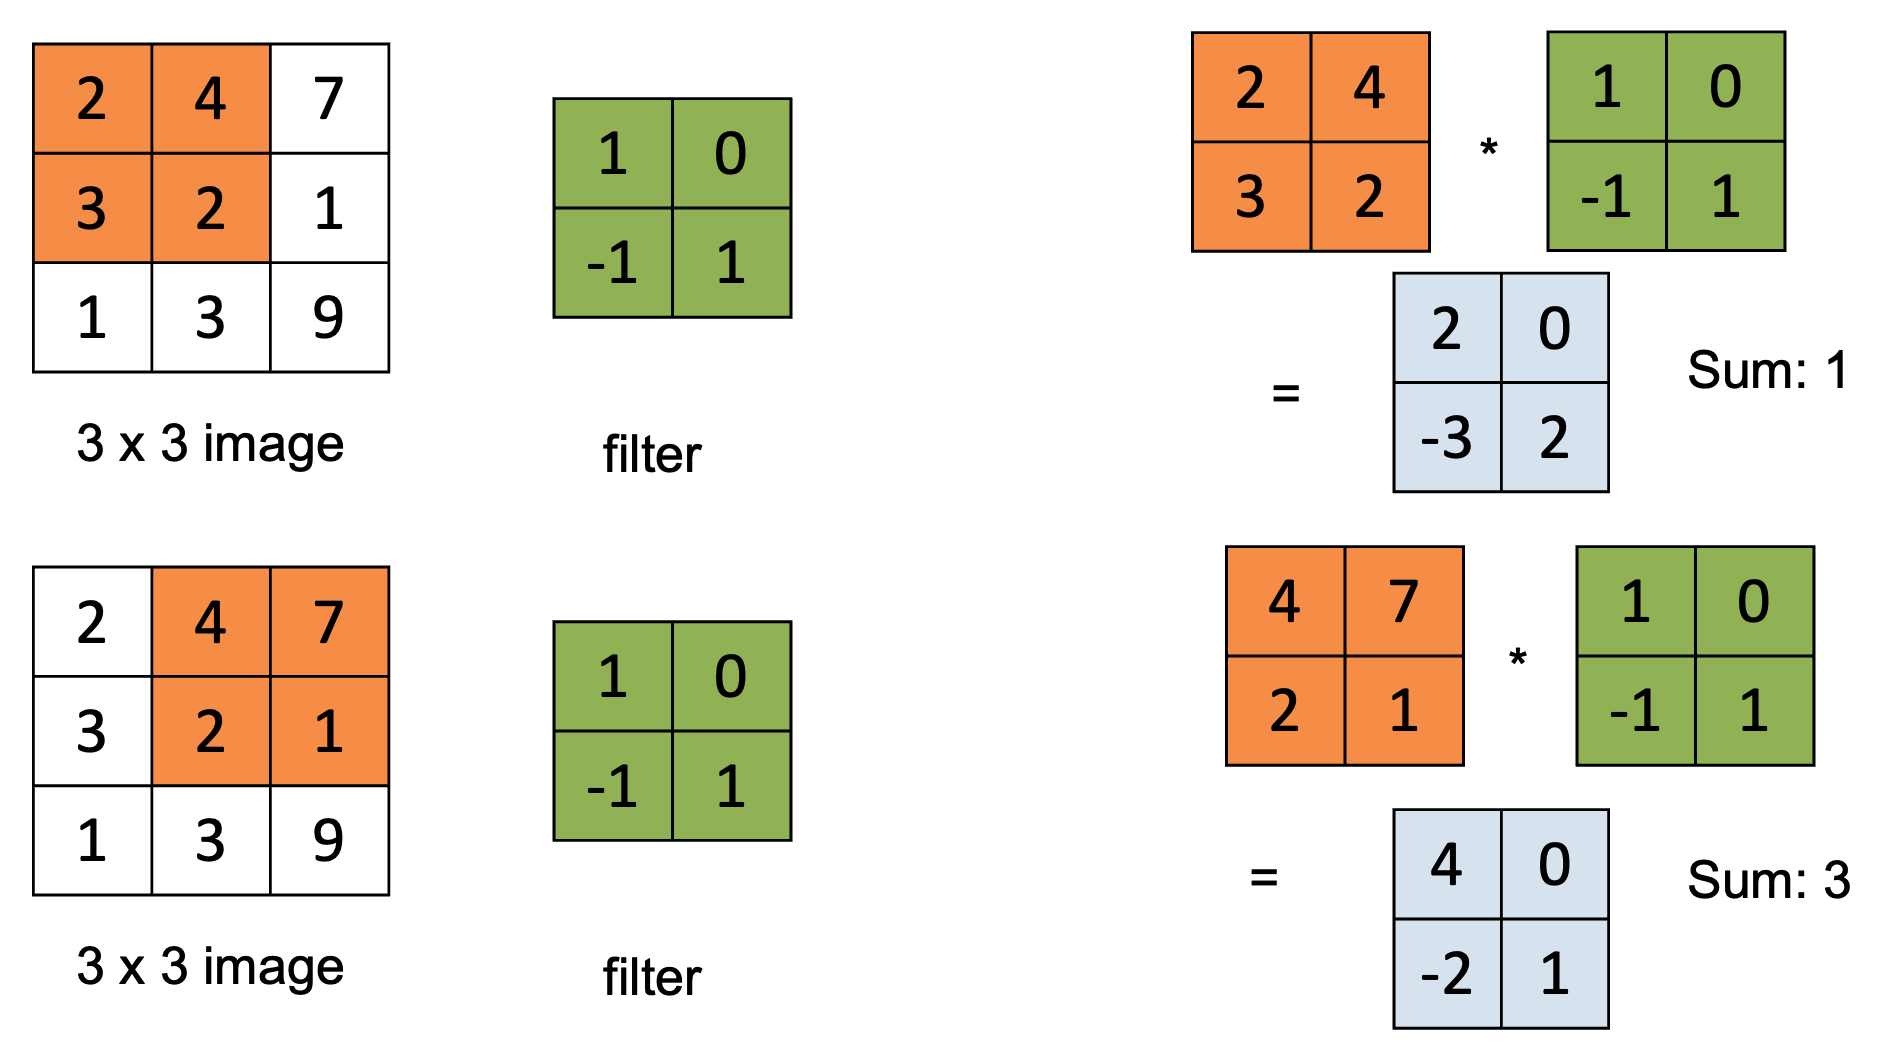

In [5]:
display.Image("figures/cnn_hint.png",width=500,height=300)


(For simplicity, the bias term is omitted in this figure)

### To Do:
- Implement forward pass of convolution layer (`Conv.naive_forward` function in `HW_YourAnswer.py` file) <br>
- Here, we restrict your implementation. You should use `Conv._find_roi` function when implementing `Conv.naive_forward` function.
- You do not have to consider computational efficiency.

Let's check with simple case. (Same as the above figure)

In [16]:
# Define a single 4x4 image, single channel
# Data format
# x: Input data of shape (H, W, C), here, (3,3,1)
# w:  Filter weights of shape (FH, FW, C), here, (2,2,1)

x=np.array([[2,4,7],[3,2,1],[1,3,9]])
x=np.expand_dims(x,axis=(0,-1))
print("shape of x: ")
print(x.shape)

w=np.array([[1,0],[-1,1]])
w=np.expand_dims(w,axis=(0,-1))
print("shape of w: ")
print(w.shape)

# We did not consider bias and zero-padding. stride is set for 1
b = np.array([0])
conv_param = {'stride': 1, 'pad': 0}


out,_ = Conv.naive_forward(x, w,b,conv_param)


print("\nConvolved Output:")
print(out[0,:,:,0])

# The output will be [[1. 3.]
#                     [5. 8.]]




shape of x: 
(1, 3, 3, 1)
shape of w: 
(1, 2, 2, 1)
b = array([0])
padded_x[0, :, :, :].shape=(3, 3, 1)
conv.shape=(2, 2, 1)
c_sum=array([1])
padded_x[0, :, :, :].shape=(3, 3, 1)
conv.shape=(2, 2, 1)
c_sum=array([3])
padded_x[0, :, :, :].shape=(3, 3, 1)
conv.shape=(2, 2, 1)
c_sum=array([5])
padded_x[0, :, :, :].shape=(3, 3, 1)
conv.shape=(2, 2, 1)
c_sum=array([8])

Convolved Output:
[[1. 3.]
 [5. 8.]]


Let's check your implementation with more general case.

In [18]:
x_shape = (2, 4, 4, 3)
w_shape = (3, 4, 4, 3)
x = np.linspace(-0.1, 0.9, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.1, 0.5, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.2, 0.3, num=3)
conv_param = {'stride': 2, 'pad': 1}

out, _ = Conv.naive_forward(x, w, b, conv_param)
correct_out = np.array([[[[-0.02202061,  0.60003681,  1.22209422],
   [-0.03036805,  0.76340817,  1.55718439]],
  [[-0.18419948,  1.12473316 , 2.43366581],
   [-0.27840633,  1.20224512,  2.68289658]]],
 [[[ 0.38819654,  3.75775488,  7.12731321],
   [ 0.20813029,  3.74940743,  7.29068458]],
  [[-0.46085756 , 3.595576 ,   7.65200957],
   [-0.72678322,  3.50136916 , 7.72952153]]]])

# Your output (difference) should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

b = array([-0.2 ,  0.05,  0.3 ])
padded_x[0, :, :, :].shape=(6, 6, 3)
conv.shape=(4, 4, 3)
c_sum=array([0.0540265 , 0.05906146, 0.06489142])
padded_x[0, :, :, :].shape=(6, 6, 3)
conv.shape=(4, 4, 3)
c_sum=array([0.15896577, 0.1830806 , 0.20799043])
padded_x[0, :, :, :].shape=(6, 6, 3)
conv.shape=(4, 4, 3)
c_sum=array([0.26390504, 0.30709974, 0.35108944])
padded_x[0, :, :, :].shape=(6, 6, 3)
conv.shape=(4, 4, 3)
c_sum=array([0.05124402, 0.05627898, 0.06210894])
padded_x[0, :, :, :].shape=(6, 6, 3)
conv.shape=(4, 4, 3)
c_sum=array([0.21342289, 0.23753773, 0.26244755])
padded_x[0, :, :, :].shape=(6, 6, 3)
conv.shape=(4, 4, 3)
c_sum=array([0.37560177, 0.41879647, 0.46278616])
padded_x[0, :, :, :].shape=(6, 6, 3)
conv.shape=(4, 4, 3)
c_sum=array([-3.31247700e-05,  5.00184026e-03,  1.08317998e-02])
padded_x[0, :, :, :].shape=(6, 6, 3)
conv.shape=(4, 4, 3)
c_sum=array([0.33386456, 0.35797939, 0.38288922])
padded_x[0, :, :, :].shape=(6, 6, 3)
conv.shape=(4, 4, 3)
c_sum=array([0.66776224, 0.710

## Exercise 1.2: efficient forward pass of convolutional layer


In the previous implementation of `Conv.naive_forward` function, we did not care about computational inefficiency.

The simple naive implementation would require four for-loops (over N, H', W', F) where H'=output feature map height, W'=output feature map width

We can accelerate it by utilizing below `im2col` concept.

This implementation helps to remove the for-loop related to the filter size (F).

You can make the implementation more efficiently by also removing the other for-loops, but we only consider about removing the for-loop related to the filter size (F).

**Hint**: the main point of implementation for efficient convolution operation:  `im2col`

  Specifically,
  - Input matrix and filter matrix into columns, which can help to vectorize operations.
  - For the input matrix, extract the receptive fields (roi), vectorize them, and make those columns into single matrix
  - Then, do dot product using two matrix

See the below figure for better understanding. This process is called image to column (`im2col`).






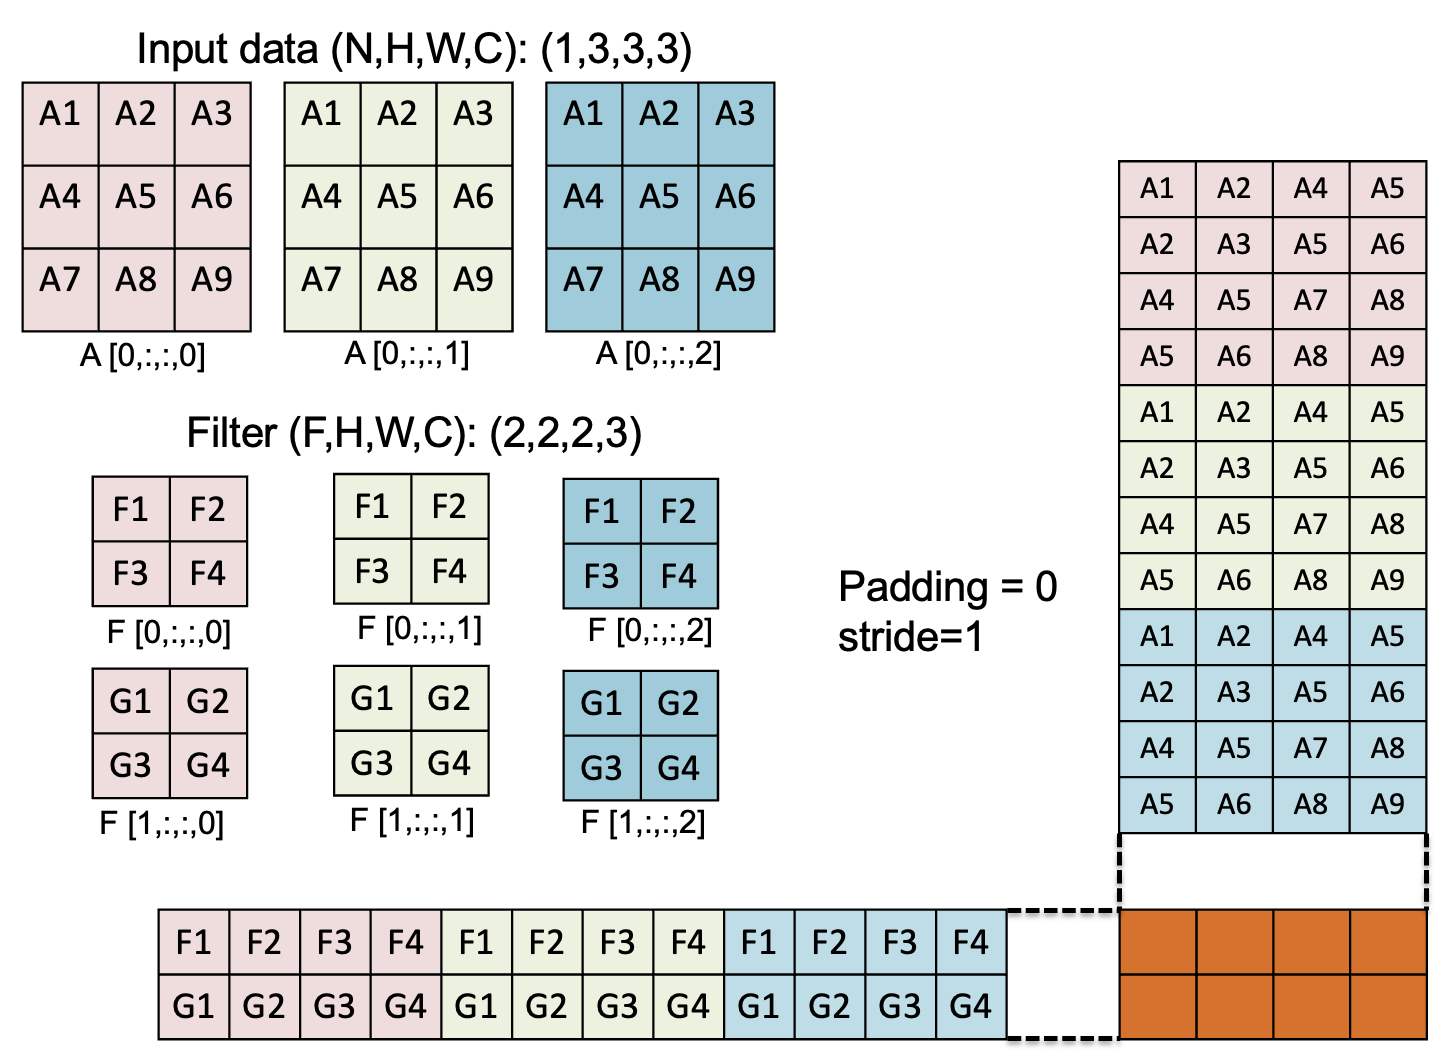

In [8]:
from IPython.display import Image
display.Image("figures/im2col.png",width=500,height=300)

Note that this concept can be used not only in the forward pass but also in the backward pass.


In order to vectorize the matrix or tensor, you can use numpy.reshape function (https://numpy.org/doc/stable/reference/generated/numpy.reshape.html).

Here is the example.

In [10]:
image = np.array([
    [2,4],
    [3,2]
])
filter = np.array([
    [1,0],
    [-1,1]
])

print ('image: ', image.reshape(1,-1))
print('filter: ', filter.reshape(1,-1))
print ('elementwise multiplication of image and filter: ', image.reshape(1,-1)* filter.reshape(1,-1) )


image:  [[2 4 3 2]]
filter:  [[ 1  0 -1  1]]
elementwise multiplication of image and filter:  [[ 2  0 -3  2]]


### To Do:
- Implement efficient version of convolution layer (`Conv.forward` function in `HW_YourAnswer.py` file) <br>
- Here, we restrict your implementation. You should use `Conv._find_roi` function when implementing `Conv.forward` function.


In [11]:
x_shape = (2, 4, 4, 3)
w_shape = (3, 4, 4, 3)
x = np.linspace(-0.1, 0.9, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.1, 0.5, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.2, 0.3, num=3)
conv_param = {'stride': 2, 'pad': 1}

out, _ = Conv.forward(x, w, b, conv_param)
correct_out = np.array([[[[-0.02202061,  0.60003681,  1.22209422],
   [-0.03036805,  0.76340817,  1.55718439]],
  [[-0.18419948,  1.12473316 , 2.43366581],
   [-0.27840633,  1.20224512,  2.68289658]]],
 [[[ 0.38819654,  3.75775488,  7.12731321],
   [ 0.20813029,  3.74940743,  7.29068458]],
  [[-0.46085756 , 3.595576 ,   7.65200957],
   [-0.72678322,  3.50136916 , 7.72952153]]]])

# Your output (difference) should be around e-8
print('Testing conv_forward')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

### Time check

Here is the time difference with our (for-loop based) naive version implementation.

(We use four for-loops (over N, H', W', F) for the naive implementation. )

Your implementation should be at least 20x faster than our naive for-loop based implementation.

As mentioned before, avoiding the looping over the number of filter (F) is the main point here.

Thus, you do not have to consider other options for further accelerating the computation. (For this, much more complex implementation would be required)

In [ ]:
from time import time
from comparison import naive_forward
np.random.seed(231)
x = np.random.randn(100, 31, 31,3)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 16, 16,25)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = naive_forward(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = Conv.forward(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

## Exercise 2.2: backward pass of convolutional layer

Now, we will implement the backward pass of convolution layer.

We suggest some hints for implementing them.

We consider simple case.

- Input x shape of 3 X 3

- Filter w shape of 2 X 2

- Thus, output O is shape of 2 X 2


In [ ]:
display.Image("figures/backward_1.png",width=900,height=500)

In [ ]:
display.Image("figures/backward_2.png",width=900,height=500)

In Lecture 7, we individually computed  each element of a gradient matrix, denoted as the gradient of 𝐹_𝑖𝑗, (figure (a))).

However, this approach can become intricate when the stride exceeds 1, necessitating the use of dilated convolution.

From an implementation standpoint, it's more straightforward to compute the entire gradient matrix at once by leveraging intermediate results, as illustrated in figure (b).

Specifically, we start by computing the values for each of the four boxes (colored as red, green, purple, and blue) and subsequently aggregate them while preserving their respective positions.

(How to calculate each boxes are presented in figure (d))

Then, as described in (c), we can get the same result with (a).


In [ ]:
display.Image("figures/backward_3.png",width=900,height=600)

In [ ]:
display.Image("figures/backward_4.png",width=800,height=600)

As can be verified in the figure (d), this process has the exact same order with the forward pass of convolution layer.
(Namely, the cases where stride (>1) are inherently considered. )

Note that element-wise multiplication (not dot product) is applied in (d) step.

This trick can also be utilized similariy when implementing the gradients (w.r.t. input).


### To Do:
- Implement the backward pass for the convolution operation in the `Conv.backward` function in `HW_YourAnswer.py`.

Here, you do not have to consider computational efficiency here. 

But, if you could implement more efficiently by using similar concept described in Exercise 1.2, you have a chance to get a bonus point. 

Refer to Exercise 4 for more information on earning a bonus point.



In [ ]:
np.random.seed(231)
x = np.random.randn(4, 5, 5, 3)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 5, 5, 2)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: Conv.forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: Conv.forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: Conv.forward(x, w, b, conv_param)[0], b, dout)

out, cache = Conv.forward(x, w, b, conv_param)
dx, dw, db = Conv.backward(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

# Exercise 2: Pooling
## Exercise 2.1: forward pass of (max / average) pooling


<table>
<td>
<img src="https://github.com/csaybar/DLcoursera/blob/master/Convolutional%20Neural%20Networks/week01/images/max_pool1.png?raw=1" style="width:500px;height:300px;">
<td>

<td>
<img src="https://github.com/csaybar/DLcoursera/blob/master/Convolutional%20Neural%20Networks/week01/images/a_pool.png?raw=1" style="width:500px;height:300px;">
<td>
</table>

### To do:
- Implement `Pooling.forward` function in `HW_YourAnswer.py` file <br>
- In pooling operation, we assume that the pooling area is square (pool_height == pool_width)

**Hint**: Tricks used in convolution layer can also be similarly applied.

Here, you do not have to consider the efficiency. 

However, if you could implement more efficiently, you have a chance to get a bonus point. (It is not mandatory)

Refer to Exercise 4 for more information on earning a bonus point.


In [ ]:
from HW_YourAnswer import *
x_shape = (2, 4, 4, 3)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_size': 2, 'stride': 2, 'pool_type': "max"}

out, _ = Pooling.forward(x, pool_param)

correct_out = np.array([[[[-0.18947368, -0.18210526, -0.17473684],
   [-0.14526316, -0.13789474, -0.13052632]],
  [[-0.01263158, -0.00526316,  0.00210526],
   [ 0.03157895,  0.03894737,  0.04631579]]],
 [[[ 0.16421053,  0.17157895,  0.17894737],
   [ 0.20842105,  0.21578947,  0.22315789]],
  [[ 0.34105263,  0.34842105,  0.35578947],
   [ 0.38526316,  0.39263158,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-7 or less.
print('Testing max pooling function:')
print('difference: ', rel_error(out, correct_out))

pool_param = {'pool_size': 2, 'stride': 2, 'pool_type': "avg"}

out, _ = Pooling.forward(x,  pool_param)
correct_out = np.array([[[[-0.24473684, -0.23736842, -0.23      ],
   [-0.20052632, -0.19315789, -0.18578947]],
  [[-0.06789474, -0.06052632, -0.05315789],
   [-0.02368421, -0.01631579, -0.00894737]]],
 [[[ 0.10894737,  0.11631579,  0.12368421],
   [ 0.15315789,  0.16052632,  0.16789474]],
  [[ 0.28578947,  0.29315789,  0.30052632],
   [ 0.33,        0.33736842,  0.34473684]]]])
# Compare your output with ours. Difference should be on the order of e-7 or less.
print('Testing avg pooling function:')
print('difference: ', rel_error(out, correct_out))

## Exercise 2.2: backward pass of (max / average) pooling

### To do:
- Implement `Pooling.backward` function in `HW_YourAnswer.py` file <br>

Here, you do not have to consider the efficiency.

However, if you could implement more efficiently, you have a chance to get a bonus point. (It is not mandatory)

Refer to Exercise 4 for more information on earning a bonus point.

In [ ]:
np.random.seed(231)
x = np.random.randn(3, 8, 8, 2)
dout = np.random.randn(3, 4, 4, 2)

pool_param = {'pool_size': 2, 'stride': 2, 'pool_type': "max"}


dx_num = eval_numerical_gradient_array(lambda x: Pooling.forward(x, pool_param)[0], x, dout)

out, cache = Pooling.forward(x, pool_param)
dx = Pooling.backward(dout, cache)

# Your error should be on the order of e-12
print('Testing max pooling function:')
print('dx error: ', rel_error(dx, dx_num))

pool_param = {'pool_size': 2, 'stride': 2, 'pool_type': "avg"}
dx_num = eval_numerical_gradient_array(lambda x: Pooling.forward(x, pool_param)[0], x, dout)

out, cache = Pooling.forward(x,pool_param)
dx = Pooling.backward(dout, cache)

# Your error should be on the order of e-11
print('Testing avg pooling function:')
print('dx error: ', rel_error(dx, dx_num))

# Exercise 3: Batch Normalization for CNN

Normally, batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`.

For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, H, W, C)` and produce outputs of shape `(N, H, W, C)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect every feature channel's statistics e.g. mean, variance to be relatively consistent both between different images, and different locations within the same image -- after all, every feature channel is produced by the same convolutional filter!

Therefore, spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over the minibatch dimension `N` as well the spatial dimensions `H` and `W`.

As we learned in Lecture 8 (slide 35), a single fixed empirical mean/std obtained during training is used in the test time.

The empirical mean/std (running_mean, running_std) is calculated in the training time as :

$u_{moving} =  \alpha u_{moving} + (1-\alpha) u_{B}$

$\sigma_{moving}^2  = \alpha \sigma_{moving}^2 + (1-\alpha) \sigma_{B}^2$

where where $\alpha$ is momentum and $u_{B}, \sigma_{B}^2$ is calculated mean,var from the current mini-batch


[Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)





In [ ]:
display.Image("figures/bn.png",width=400,height=400)

## Exercise 3.1: forward pass of spatial batch normalization

### To do:
- Implement `BatchNorm.forward` function in `HW_YourAnswer.py` file <br>

In [ ]:
np.random.seed(231)

# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization.
N, H, W, C = 7, 4, 4, 3
x = 8 * np.random.randn(N, H, W, C) + 4

print('Before spatial batch normalization:')
print('  shape: ', x.shape)
print('  means: ', x.mean(axis=(0, 1, 2)))
print('  stds: ', x.std(axis=(0, 1, 2)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = BatchNorm.forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  shape: ', out.shape)
print('  means: ', out.mean(axis=(0, 1, 2)))
print('  stds: ', out.std(axis=(0, 1, 2)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([1, 2, 4]), np.asarray([8, 4, 3])
out, _ = BatchNorm.forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  shape: ', out.shape)
print('  means: ', out.mean(axis=(0, 1, 2)))
print('  stds: ', out.std(axis=(0, 1, 2)))

In [ ]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, H, W, C = 10, 11, 12, 6
bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, H, W, C) + 13
  BatchNorm.forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, H, W, C) + 13
a_norm, _ = BatchNorm.forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 1, 2)))
print('  stds: ', a_norm.std(axis=(0, 1, 2)))

## Exercise 3.2: backward pass of spatial batch normalization

### To do:
- Implement `BatchNorm.backward` function in `HW_YourAnswer.py` file <br>

In [ ]:
np.random.seed(230)
N, H, W, C = 2, 4, 5, 3
x = 5 * np.random.randn(N, H, W, C) + 13
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, H, W, C)

bn_param = {'mode': 'train'}
fx = lambda x: BatchNorm.forward(x, gamma, beta, bn_param)[0]
fg = lambda gamma: BatchNorm.forward(x, gamma, beta, bn_param)[0]
fb = lambda beta: BatchNorm.forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

#You should expect errors of magnitudes between 1e-12~1e-06
_, cache = BatchNorm.forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = BatchNorm.backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

# Exercise 4:  Convolutional Neural Network

Now, we can put the layers implemented above together into a simple convolutional network.

Complete the implementation of the `numpy_CNN` class in `HW_YourAnswer_cnn.py` .

Remember you can use pre-defined layers (already imported for you) defined in  `helper_functions.py` in your implementation.



## Data preprocessing

We will use the CIFAR10 dataset as we did in HW-1

CIFAR10 dataset is composed of 50000 train data and 10000 test data. For our exercises, we will selectively use subsets of these images: 10,000 for training, 1,000 for validation, and 1,000 for testing.

In [ ]:
data = get_CIFAR10_data()

print('Train data shape: ', data["X_train"].shape)
print('Train labels shape: ', data['y_train'].shape)
print('Validation data shape: ', data['X_val'].shape)
print('Validation labels shape: ', data['y_val'].shape)
print('Test data shape: ', data['X_test'].shape)
print('Test labels shape: ', data['y_test'].shape)

## Sanity Check Loss
After you build a new network, one of the first things you should do is to sanity check the loss. When we add regularization, the loss should go up slightly.

In [ ]:
model = numpy_CNN()

N = 50
X = np.random.randn(N, 32, 32, 3)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)


## Train the Network
By training the three-layer convolutional network for one epoch, you could achieve greater than 35% accuracy on the training set.

However, if you naively implement the backward pass of convolution layer and the forward/backward pass of pooling layer without any consideration of computational efficiency,

it would take **several hours** to train this simple network (under the default Colab setting). Nevertheless, as long as your code is executable, you'll secure a point, regardless of how long it takes.

### Bonus point (efficient implementation)

Achieving a training time of less than 10 minutes for a single epoch (under the default Colab setting) will earn you a bonus point. Note that this is not mandatory.

For this, you need to consider the efficient implementation of the backward pass of convolution layer and the forward/backward pass of pooling layer (`Conv.backward`,`Pooling.forward`, `Pooling.backward`).

Specifically, if you can avoid the for-loop for the number of filter ('F') in `Conv.backward` and  for-loop for the channel dimension ('C') in `Pooling.forward` and `Pooling.backward`, you could achieve a training time of less than 10 minutes.

While further optimizations can be achieved by eliminating other loops, you do not have to consider other options in this assignment.

- Backward pass of convolution layer: avoids looping over the number of filter (F)
    - Similar trick introduced in Exercise 1.2 can also be applied.

- Forward / Backward pass of pooling layer: avoids looping over the channel dimension (C)
    - Utilize broadcasting capabilities of Numpy. 

If you choose to implement this, make your changes in the `Conv.backward`, `Pooling.forward`, `Pooling.backward` functions within the `HW_YourAnswer.py` file.

In [ ]:
from time import time

model = numpy_CNN(weight_scale=0.001, hidden_dim=500, reg=0.001)
t0 = time()
solver = Solver(
    model,
    data,
    num_epochs=1,
    batch_size=50,
    optim_config={'learning_rate': 1e-3,},
    verbose=True,
    print_every=20
)
solver.train()
t1 = time()

print('Trainig time: %fs' % (t1 - t0))

In [ ]:
# Print final training accuracy.
print(
    "Full data training accuracy:",
    solver.check_accuracy(data['X_train'], data['y_train'])
)

In [ ]:
# Print final validation accuracy.
print(
    "Full data validation accuracy:",
    solver.check_accuracy(data['X_val'], data['y_val'])
)

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

In [ ]:
from utils import visualize_grid

grid = visualize_grid(model.params['W1'])
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()